In [2]:
# import necessary libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# BigQuery settings
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
import google.auth

credentials, your_project_id = google.auth.default( scopes=["https://www.googleapis.com/auth/cloud-platform"])
bqclient = bigquery.Client(credentials=credentials, project="som-nero-phi-jonc101",)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information abou

In [4]:
df_list=[]

### Unique Workstations

In [5]:
query = '''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "%lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Result%" OR metric_name like "%result%" 
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"

  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),

  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    COUNT(DISTINCT workstation_id) AS num_unq_wrkstn
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4
)

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    AVG(num_unq_wrkstn) AS num_unq_wrkstn
FROM 
    ALL_TT_METRICS
GROUP BY 
    1,2,3
'''



In [6]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'num_unq_wrkstn']]
print(dataframe.head())
df_list.append(dataframe)

   pat_enc_csn_id_coded  num_unq_wrkstn
0          131064677452        1.961538
1          131112319567        2.148148
2          131074325509        4.266667
3          131201965445        1.629630
4          131137639110        2.344828


### Task Switching

In [7]:
query = '''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT
AL.rit_uid,
AL.pat_enc_csn_id_coded,
min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time,
min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,
FROM `noshad.cohort_AL_60` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.rit_uid, AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),
PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
FROM `noshad.cohort_AL_60` as AL
WHERE
(metric_name like "%Lab%" OR metric_name like "%lab%"
OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
OR metric_name like "%Order%" OR metric_name like "%order%"
OR metric_name like "%Result%" OR metric_name like "%result%"
OR metric_name like "%Medications%" OR metric_name like "%medications%"
OR metric_name like "%MAR%"
OR metric_name like "%Note%" OR metric_name like "%note%"
OR metric_name like "%History%" OR metric_name like "%history%"
OR metric_name like "%Imag%" OR metric_name like "%imag%"
)
GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),
TT AS
(
SELECT
*
FROM
TPAP_ACTUAL_TIMES
INNER JOIN
PROVIDER_MAPPING
USING
(pat_enc_csn_id_coded)
),
-- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE
AL.rit_uid=TMP.ANON_ID
AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),
FILTERED_EVENTS AS (
SELECT
TT.*,
AL_ALL_ACTUAL_TIMES.access_time_real,
AL_ALL_ACTUAL_TIMES.metric_name,
AL_ALL_ACTUAL_TIMES.workstation_id,
AL_ALL_ACTUAL_TIMES.rit_uid AS non_index_uid,
LEAD(AL_ALL_ACTUAL_TIMES.rit_uid)
OVER (PARTITION BY pat_enc_csn_id_coded, provider_id ORDER BY access_time_real ASC) AS next_patient_id
FROM
TT
INNER JOIN
AL_ALL_ACTUAL_TIMES
ON
AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id
WHERE
access_time_real BETWEEN tw_start_time AND tw_end_time
ORDER BY
pat_enc_csn_id_coded, provider_id, access_time_real
),
TASK_SWITCHING AS
(
SELECT
*,
(CASE WHEN non_index_uid = next_patient_id THEN 0 ELSE 1 END) AS task_switched
FROM FILTERED_EVENTS
),
PROVIDER_LEVEL_SWITCHING AS
(
SELECT
DATETIME_DIFF(tpa_admin_time, emergency_admit_time, MINUTE) AS tpa_min,
pat_enc_csn_id_coded,
provider_id,
SUM(task_switched) AS total_switching
FROM TASK_SWITCHING
GROUP BY 1, pat_enc_csn_id_coded, provider_id
)

SELECT 
    pat_enc_csn_id_coded,
    tpa_min,
    AVG(total_switching ) AS avg_task_switching
FROM 
    PROVIDER_LEVEL_SWITCHING
GROUP BY 
    1,2
'''

In [8]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'avg_task_switching', 'tpa_min']]
print(dataframe.head())
df_list.append(dataframe)

   pat_enc_csn_id_coded  avg_task_switching  tpa_min
0          131063859843           36.571429       79
1          131224318222           56.516129       71
2          131058864429           44.882353       38
3          131180358175           43.000000       23
4          131030359833           19.666667       30


### Chart views

In [9]:
query='''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.rit_uid,
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,
FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.rit_uid, AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),
PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    (metric_name like "%Lab%" OR metric_name like "%lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Report%" OR metric_name like "%report%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"    
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"
    )
  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),
TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),
  -- Generate AL with actual times where metric name is Encounter%. Every chart view should have at least one Encounter metric name.
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE 
    AL.rit_uid=TMP.ANON_ID
    AND metric_name like "%Encounter%"
ORDER BY AL.rit_uid
),
FILTERED_EVENTS AS (
SELECT 
  TT.*, 
  AL_ALL_ACTUAL_TIMES.access_time_real, 
  AL_ALL_ACTUAL_TIMES.metric_name, 
  AL_ALL_ACTUAL_TIMES.workstation_id,
  AL_ALL_ACTUAL_TIMES.rit_uid AS non_index_uid,
  LEAD(AL_ALL_ACTUAL_TIMES.rit_uid)
    OVER (PARTITION BY pat_enc_csn_id_coded, provider_id ORDER BY access_time_real ASC) AS next_patient_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
    AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id
WHERE
  access_time_real BETWEEN tw_start_time AND tw_end_time
ORDER BY 
    pat_enc_csn_id_coded, provider_id, access_time_real
),
TASK_SWITCHING AS
(
SELECT 
    *,
    (CASE WHEN non_index_uid = next_patient_id THEN 0 ELSE 1 END) AS task_switched 
FROM FILTERED_EVENTS
),
PROVIDER_LEVEL_METRIC AS
(
SELECT 
    DATETIME_DIFF(tpa_admin_time, emergency_admit_time, MINUTE) AS tpa_min,
    pat_enc_csn_id_coded, 
    provider_id, 
    COUNT(*) AS view_count
FROM FILTERED_EVENTS
GROUP BY 1, pat_enc_csn_id_coded, provider_id
)

SELECT tpa_min, pat_enc_csn_id_coded, AVG(view_count) AS view_count
FROM PROVIDER_LEVEL_METRIC
GROUP BY 1,2
'''


In [10]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'view_count']]
print(dataframe.head())
df_list.append(dataframe)

   pat_enc_csn_id_coded  view_count
0          131026388252   13.681818
1          131154444987   12.107143
2          131024133934   11.411765
3          131015332320    3.454545
4          131020124694    4.153846


### Days Since Last TPA Case

In [11]:
query='''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "%lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Result%" OR metric_name like "%result%" 
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"

  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),

  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    DATETIME_DIFF(tpa_admin_time, LAG(emergency_admit_time) -- ,1,DATETIME(2000,1,1,0,0,0)
    OVER (PARTITION BY provider_id ORDER BY emergency_admit_time ASC), DAY) AS day_since_last_tpa
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4
ORDER BY emergency_admit_time
),

ALL_TT_METRICS_2 AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    (CASE WHEN day_since_last_tpa IS NOT NULL THEN day_since_last_tpa ELSE 30 END) AS day_since_last_tpa
FROM 
    ALL_TT_METRICS
),

FINAL AS(
SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    MIN(day_since_last_tpa) AS day_since_last_tpa
FROM 
    ALL_TT_METRICS_2
GROUP BY 
    1,2,3
)

SELECT * FROM FINAL
'''

In [12]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'day_since_last_tpa']]
print(dataframe.head())
df_list.append(dataframe)

   pat_enc_csn_id_coded  day_since_last_tpa
0          131021984186                   7
1          131189048329                   3
2          131062522028                   9
3          131224318222                   7
4          131024133934                   4


### Number of previous TPA cases

In [13]:
query='''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "%lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"

  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),

  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    count(*) OVER (PARTITION BY provider_id ORDER BY UNIX_DATE(CAST(emergency_admit_time AS DATE)) RANGE BETWEEN 180 PRECEDING AND 1 PRECEDING) AS tpa_count_within_180
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4
ORDER BY emergency_admit_time
),

FINAL AS(
SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    AVG(tpa_count_within_180) AS tpa_count_within_180
FROM 
    ALL_TT_METRICS
GROUP BY 
    1,2,3
)

SELECT * FROM FINAL
'''

In [14]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'tpa_count_within_180']]
print(dataframe.head())
df_list.append(dataframe)

   pat_enc_csn_id_coded  tpa_count_within_180
0          131020540612              1.722222
1          131014376919              0.263158
2          131084159365              1.857143
3          131223517964              1.388889
4          131016108516              0.777778


### Number of join TPA cases

In [15]:
# Create a table of treatment team
query_1= '''
CREATE OR REPLACE TABLE `som-nero-phi-jonc101.noshad.moore_treatment_team`  AS
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "%lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"
 AND 
    (user_role LIKE '%Nurse%'
    OR user_role LIKE '%Primary%'
    OR user_role LIKE '%Physician%'
    )
  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),

  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4
ORDER BY emergency_admit_time
)

SELECT * FROM ALL_TT_METRICS
'''

query_2='''
WITH 

ALL_TT_METRICS AS
(SELECT * FROM `som-nero-phi-jonc101.noshad.moore_treatment_team` ),

ALL_TT_METRICS_2 AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    CONCAT(ALL_TT_METRICS.provider_id, ALL_TT_METRICS.provider_id) AS joint_providers
FROM 
    ALL_TT_METRICS
INNER JOIN 
    ALL_TT_METRICS AS ALL_TT_METRICS_COPY
USING 
    (pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time)
ORDER BY emergency_admit_time
),

ALL_TT_METRICS_3 AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    joint_providers,
    count(*) OVER (PARTITION BY joint_providers ORDER BY UNIX_DATE(CAST(emergency_admit_time AS DATE)) RANGE BETWEEN 180 PRECEDING AND 1 PRECEDING ) AS tpa_count_within_180
FROM 
    ALL_TT_METRICS_2
GROUP BY 1,2,3,4
ORDER BY emergency_admit_time
),

FINAL AS(
SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    AVG(tpa_count_within_180) AS joint_tpa_count_within_180
FROM 
    ALL_TT_METRICS_3
GROUP BY 
    1,2,3
)

SELECT * FROM FINAL
'''


In [16]:
_ = bqclient.query(query_1).result().to_dataframe()
print('query 1 executed')
dataframe = bqclient.query(query_2).result().to_dataframe()
dataframe = dataframe[['pat_enc_csn_id_coded', 'joint_tpa_count_within_180']]
print(dataframe.head())
df_list.append(dataframe)

query 1 executed
   pat_enc_csn_id_coded  joint_tpa_count_within_180
0          131018805618                    0.555556
1          131018886055                    1.000000
2          131018908601                    1.129032
3          131018945531                    2.500000
4          131019615693                    1.107143


In [17]:
print(df_list)

[     pat_enc_csn_id_coded  num_unq_wrkstn
0            131064677452        1.961538
1            131112319567        2.148148
2            131074325509        4.266667
3            131201965445        1.629630
4            131137639110        2.344828
..                    ...             ...
239          131022194138        1.428571
240          131061814802        1.600000
241          131068658088        1.333333
242          131194806134        2.000000
243          131012891143        3.000000

[244 rows x 2 columns],      pat_enc_csn_id_coded  avg_task_switching  tpa_min
0            131063859843           36.571429       79
1            131224318222           56.516129       71
2            131058864429           44.882353       38
3            131180358175           43.000000       23
4            131030359833           19.666667       30
..                    ...                 ...      ...
239          131012635841           19.666667       79
240          131072133943     

In [18]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pat_enc_csn_id_coded'],
                                            how='outer'), df_list)
df_merged

,pat_enc_csn_id_coded,num_unq_wrkstn,avg_task_switching,tpa_min,view_count,day_since_last_tpa,tpa_count_within_180,joint_tpa_count_within_180
0,131064677452,1.961538,30.307692,55,9.714286,13,1.153846,1.153846
1,131112319567,2.148148,24.888889,60,11.642857,6,2.125000,2.125000
2,131074325509,4.266667,39.000000,55,9.076923,5,2.846154,2.846154
3,131201965445,1.629630,43.814815,34,2.692308,19,2.047619,2.047619
4,131137639110,2.344828,51.482759,45,14.962963,2,2.800000,2.800000
...,...,...,...,...,...,...,...,...
239,131022194138,1.428571,73.285714,88,4.692308,13,2.928571,2.928571
240,131061814802,1.600000,36.333333,63,13.944444,3,1.466667,1.466667
241,131068658088,1.333333,1.333333,36,1.666667,6,1.666667,1.666667
242,131194806134,2.000000,2.500000,25,1.333333,30,0.500000,0.500000


In [19]:
df_merged.to_csv('all_metrics.csv')

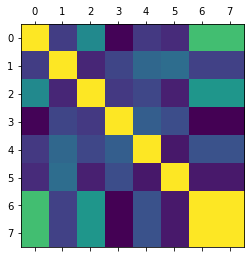

In [21]:
import matplotlib.pyplot as plt

plt.matshow(df_merged.corr())
plt.show()

In [22]:
df_merged.describe()

,pat_enc_csn_id_coded,num_unq_wrkstn,avg_task_switching,tpa_min,view_count,day_since_last_tpa,tpa_count_within_180,joint_tpa_count_within_180
count,2.440000e+02,244.000000,244.000000,244.000000,243.000000,244.000000,244.000000,244.000000
mean,1.310845e+11,1.787071,35.935950,56.422131,7.684443,11.426230,1.860006,1.860006
std,7.248948e+07,0.390425,17.037570,39.853410,5.031314,14.315906,1.073809,1.073809
min,1.310115e+11,0.500000,1.333333,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.310221e+11,1.547654,24.712121,31.750000,3.130952,3.000000,1.105357,1.105357
50%,1.310545e+11,1.711982,33.650202,48.000000,6.500000,7.000000,1.713542,1.713542
75%,1.311656e+11,1.957776,44.888327,66.250000,12.012146,16.000000,2.445385,2.445385
max,1.312295e+11,4.266667,164.000000,285.000000,23.222222,140.000000,5.714286,5.714286


### Bivariate Coefficients

In [32]:
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr 

metric_list = ['num_unq_wrkstn', 'num_unq_wrkstn', 'avg_task_switching', 'view_count', 'day_since_last_tpa', 'tpa_count_within_180', 'joint_tpa_count_within_180']
for metric in metric_list:
    X = np.nan_to_num(df_merged[metric].to_numpy().reshape((-1,1)))
    Y = np.nan_to_num(df_merged['tpa_min'].to_numpy().reshape((-1,1)))
    reg = LinearRegression().fit(X, Y)
    print('*********', metric )
    print('pearson correlation')
    print(pearsonr(np.reshape(X,(-1,)), np.reshape((Y),(-1,))))
    print('bivariate coefficients')
    print((reg.coef_, reg.intercept_)) #np.mean(X), np.median(X), np.std(X), np.min(X), np.max(X), 

********* num_unq_wrkstn
pearson correlation
(-0.035935591862111746, 0.5764143382372162)
bivariate coefficients
(array([[-3.66819817]]), array([62.97746149]))
********* num_unq_wrkstn
pearson correlation
(-0.035935591862111746, 0.5764143382372162)
bivariate coefficients
(array([[-3.66819817]]), array([62.97746149]))
********* avg_task_switching
pearson correlation
(-0.09585416954222596, 0.13542639124567257)
bivariate coefficients
(array([[-0.22421715]]), array([64.4795877]))
********* view_count
pearson correlation
(0.072349660412495, 0.26024573780986837)
bivariate coefficients
(array([[0.57153312]]), array([52.04821687]))
********* day_since_last_tpa
pearson correlation
(-0.004355877097920966, 0.9460308965114786)
bivariate coefficients
(array([[-0.01212613]]), array([56.56068711]))
********* tpa_count_within_180
pearson correlation
(-0.3126621920315055, 6.215872065997299e-07)
bivariate coefficients
(array([[-11.60416665]]), array([78.00594665]))
********* joint_tpa_count_within_180
pe